# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# load weekly sales dataset

filename = "../Assingments/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

/Users/sebastianvillota/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


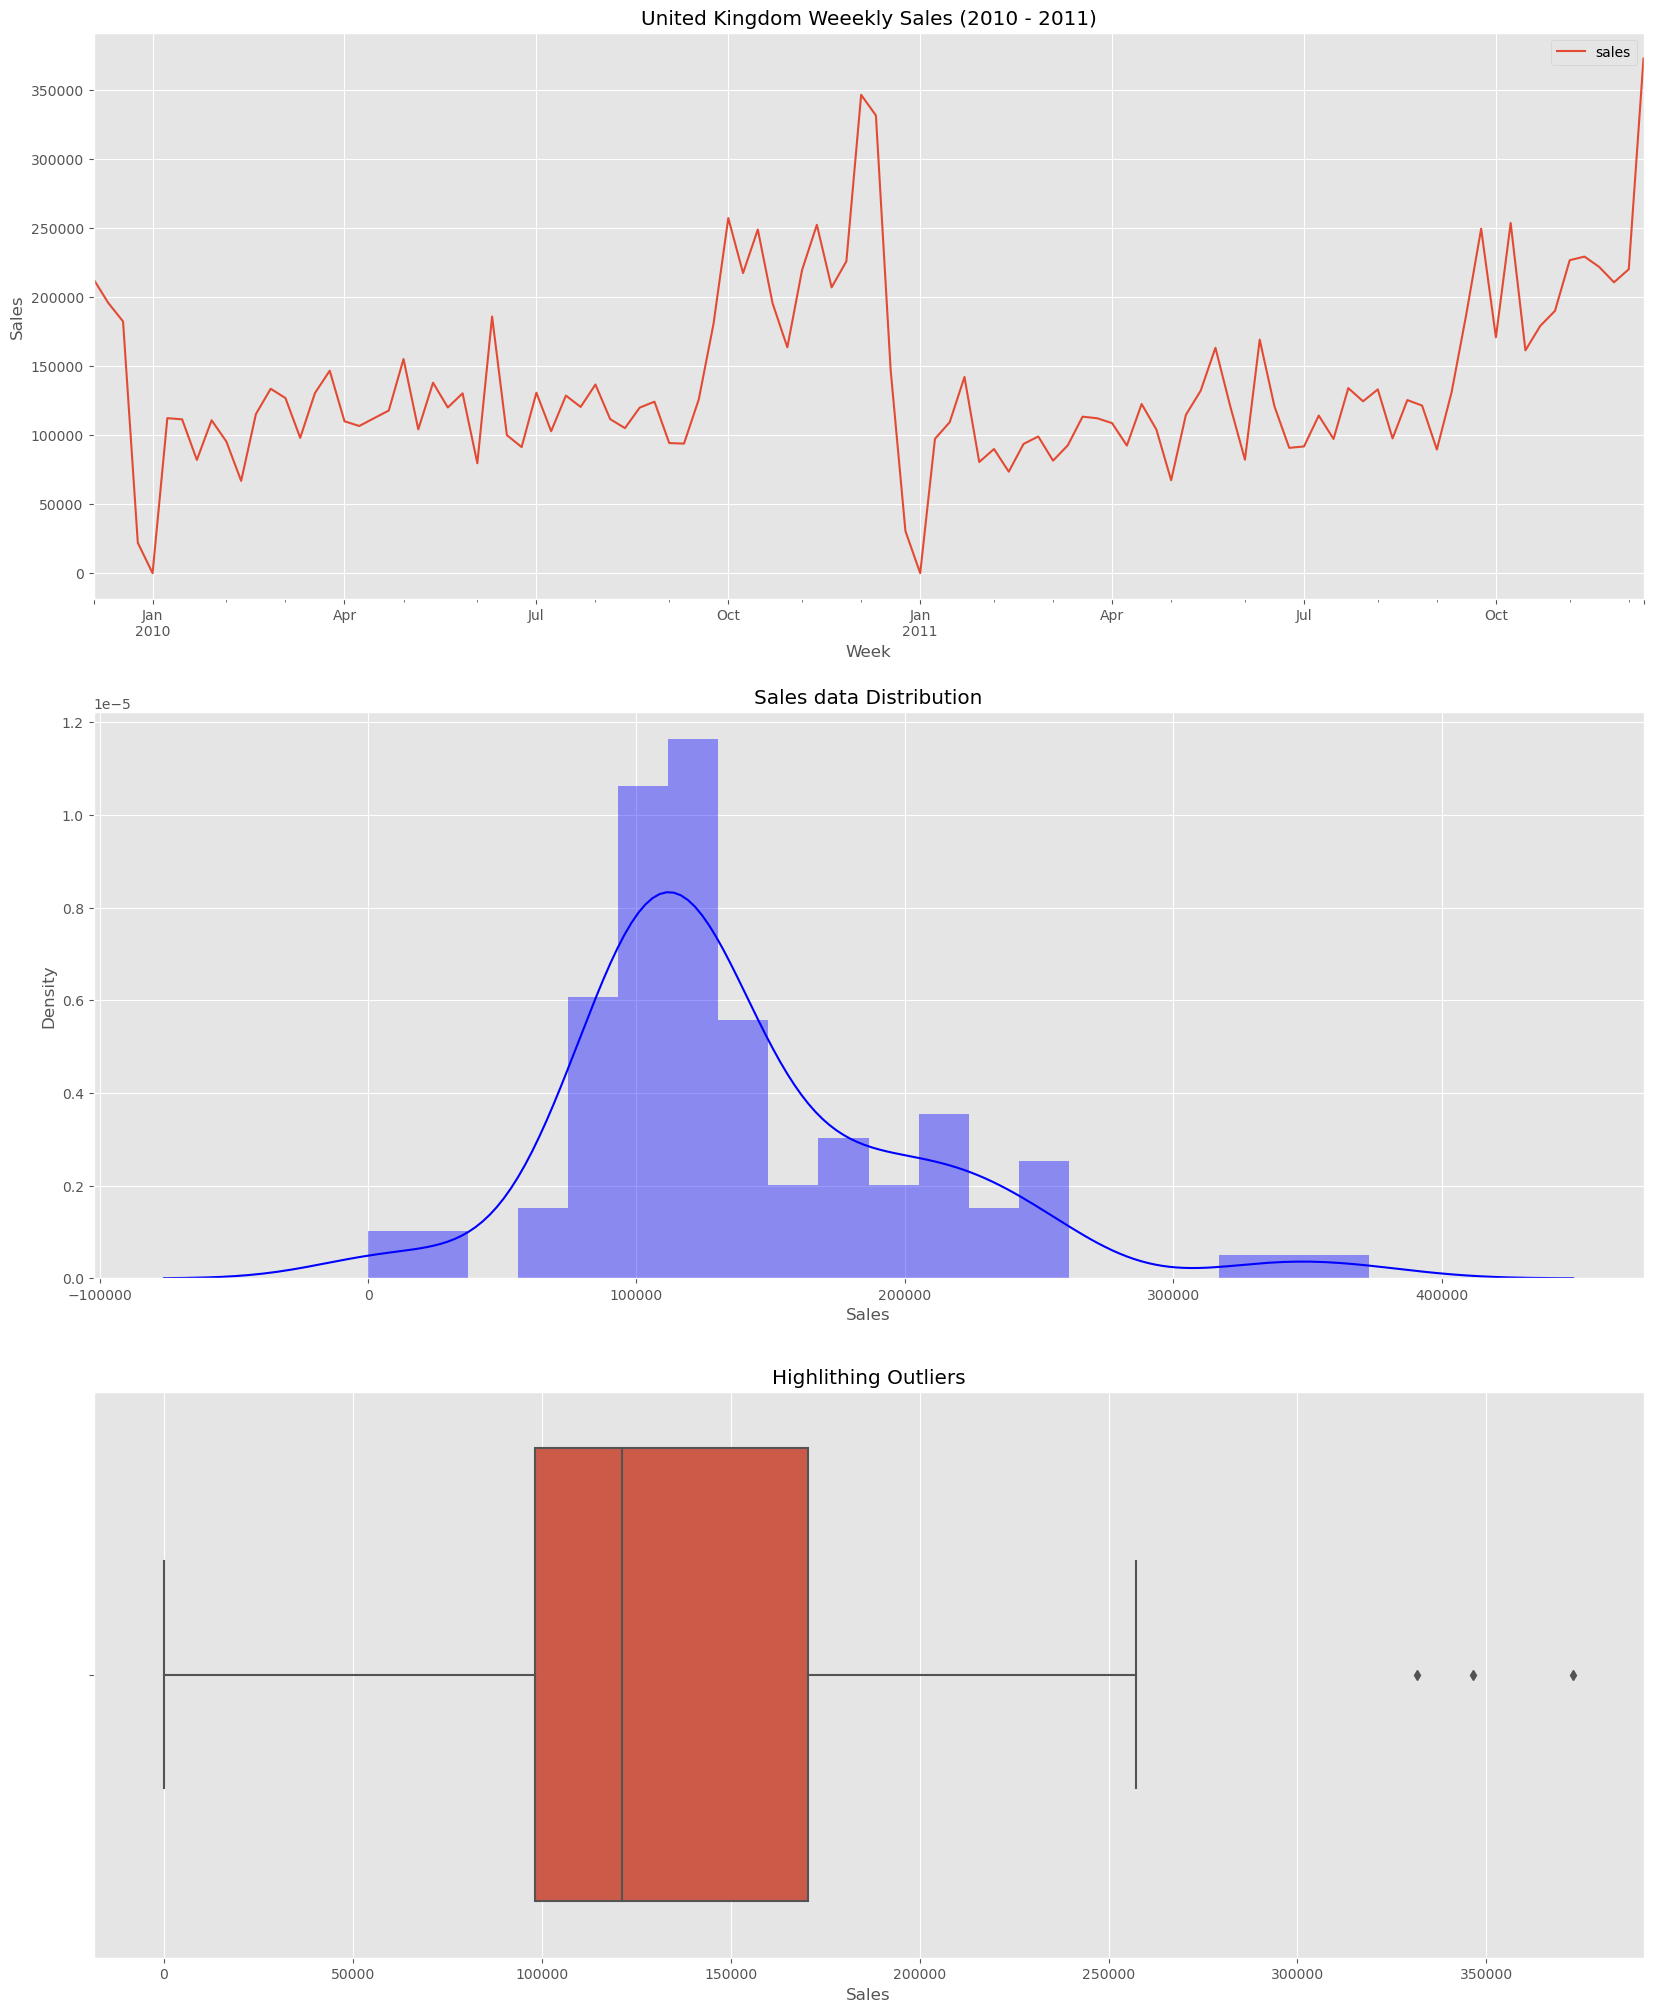

In [3]:
fig, ax = plt.subplots(figsize = (20, 25), nrows = 3)
    
df.plot(ax = ax[0])
ax[0].set_title('United Kingdom Weeekly Sales (2010 - 2011)')
ax[0].set_ylabel('Sales')
ax[0].set_xlabel('Week')

sns.distplot(df.sales, ax = ax[1], bins = 20, color = 'b')
ax[1].set_title('Sales data Distribution')
ax[1].set_xlabel('Sales')

sns.boxplot(x = df.sales, ax = ax[2])
ax[2].set_title('Highlithing Outliers')
ax[2].set_xlabel('Sales')

plt.show()

## Missing data - Missing timestamps


Check if there are missing values in the time series or in the index timestamps.

In [4]:
null_dst = df.isnull().sum()
null_index = df.index.isnull().sum()

print(f'There are {null_index} missing values in the index and {null_dst[0]} missing values in the sales column')

There are 0 missing values in the index and 0 missing values in the sales column


## Seasonality

Does the time series show any obvious seasonal pattern?

**Ans: There's seasonality pattern in the data**

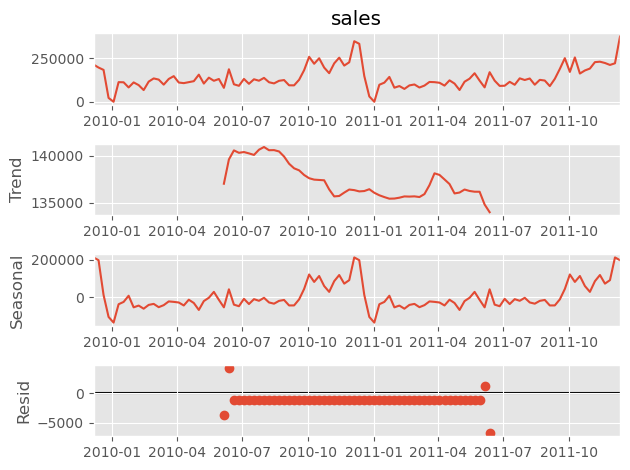

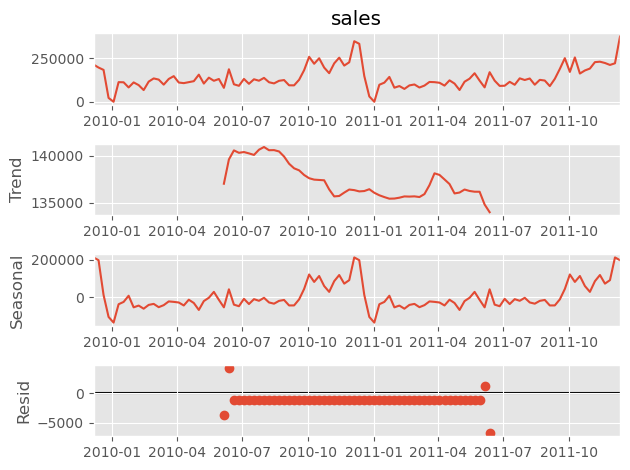

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df.sales, model = 'additive')

sd.plot()

# Feature engineering

Now, let's begin to tabularize the data.

In [6]:
# Outliers
print(df.shape)
df.query('sales > sales.quantile(0.95)')

(106, 1)


,sales
week,
2010-10-03,257301.300
2010-11-14,252428.931
2010-12-05,346578.640
2010-12-12,331660.730
2011-10-09,253713.540
2011-12-11,372946.260


(100, 1)


<AxesSubplot:xlabel='week'>

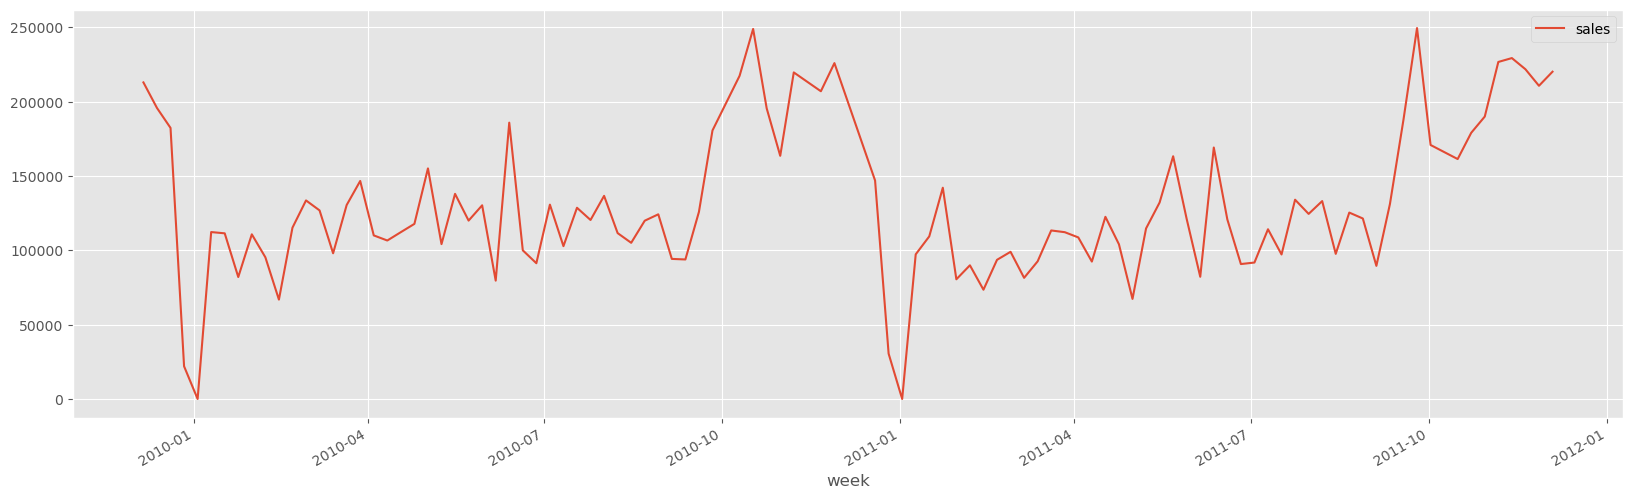

In [7]:
df = df.query('sales < sales.quantile(0.95)')
print(df.shape)
df.plot(figsize = (20, 6))

In [8]:
# Duplicated values
df.duplicated().sum()

1

In [9]:
df = df.drop_duplicates()
df.shape

(99, 1)

/Users/sebastianvillota/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


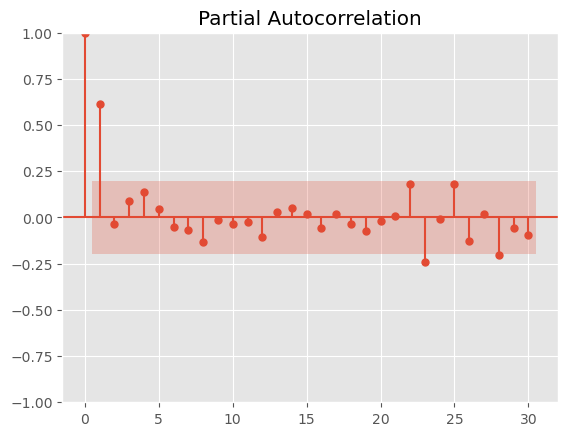

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

PACF = plot_pacf(df.sales, lags = 30)

In [11]:
def create_features(df):
    df = df.copy()
    return (df
          .assign(
               # Lag Features
               lag_w = df.sales.shift(freq = '1W'),
               lag_y = df.sales.shift(freq = '52W'),
               # Date Features
               week_of_year = df.index.weekofyear,
               month = df.index.month,
               quarter = df.index.quarter,
               year = df.index.year,
               # Window Features
               win_2w_avg = df.sales.rolling('14D').mean().shift(freq = '7D'),
               win_3w_avg = df.sales.rolling('21D').mean().shift(freq = '14D'),
               win_4w_avg = df.sales.rolling('28D').mean().shift(freq = '21D'),
               win_3w_std = df.sales.rolling('21D').std().shift(freq = '14D'),    
           ).dropna(axis = 0)   
          )

df_1 = create_features(df)
df_1.head(10)

/var/folders/xw/3hl7rpl10z98602xpng6wggc0000gn/T/ipykernel_29176/3389842766.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  week_of_year = df.index.weekofyear,


,sales,lag_w,lag_y,week_of_year,month,quarter,year,win_2w_avg,win_3w_avg,win_4w_avg,win_3w_std
week,,,,,,,,,,,
2011-01-30,80538.16,142150.28,110790.591,4,1,1,2011,125785.700,103371.100000,91620.663333,8556.020337
2011-02-06,89957.44,80538.16,95340.552,5,2,1,2011,111344.220,116297.493333,79085.676667,23192.189975
2011-02-13,73519.98,89957.44,66868.850,6,2,1,2011,85247.800,110703.186667,116297.493333,30826.062089
2011-02-20,93632.23,73519.98,115261.842,7,2,1,2011,81738.710,104215.293333,107357.660000,33188.523905
2011-02-27,99031.27,93632.23,133606.692,8,2,1,2011,83576.105,81338.526667,105516.750000,8247.906578
2011-03-06,81516.54,99031.27,126888.400,9,3,1,2011,96331.750,85703.216667,96541.465000,10709.783478
2011-03-13,92633.39,81516.54,98040.000,10,3,1,2011,90273.905,88727.826667,84411.952500,13444.194227
2011-03-20,113393.11,92633.39,130498.511,11,3,1,2011,87074.965,91393.346667,89035.230000,8969.442049
2011-03-27,112232.65,113393.11,146691.210,12,3,1,2011,103013.250,91060.400000,86925.005000,8862.683843


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [12]:
df_1.index.min(), df_1.index.max()

(Timestamp('2011-01-30 00:00:00'), Timestamp('2011-11-27 00:00:00'))

In [13]:
train = df_1.query('index < "2011-09-01"')
test = df_1.query('index >= "2011-09-01"')

features = ['lag_w', 'lag_y', 'week_of_year', 'month', 'quarter', 'year', 'win_2w_avg', 'win_3w_avg', 'win_4w_avg', 'win_3w_std']
target = ['sales']

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [14]:
from sklearn.metrics import mean_squared_error as mse

print(f"Train RMSE: {mse(train['sales'], train['lag_w'], squared = False):0.4f}, Train MSE: {mse(train['sales'],train['lag_w']):0.4f}")
print(f"Test RMSE: {mse(test['sales'], test['lag_w'], squared = False):0.4f}, Test MSE: {mse(test['sales'],test['lag_w']):0.4f}")

Train RMSE: 31264.1187, Train MSE: 977445119.8264
Test RMSE: 40170.4664, Test MSE: 1613666370.4502


## Machine Learning

In [15]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Subsetting the data
x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [16]:
l_model = Lasso(alpha = 1321, random_state = 1)

l_model.fit(x_train, y_train)

print('Lasso Model Performance')
print(f"Train RMSE: {mse(l_model.predict(x_train), y_train, squared = False):0.4f}, Train MSE: {mse(l_model.predict(x_train), y_train):0.4f}")
print(f"Test RMSE: {mse(l_model.predict(x_test), y_test, squared = False):0.4f}, Test MSE: {mse(l_model.predict(x_test), y_test):0.4f}")

Lasso Model Performance
Train RMSE: 18818.9431, Train MSE: 354152617.8386
Test RMSE: 59358.7891, Test MSE: 3523465840.4692


In [17]:
r_model = Ridge(alpha = 8, random_state = 1)

r_model.fit(x_train, y_train)
    
print('Ridge Model Performance')
print(f"Train RMSE: {mse(r_model.predict(x_train), y_train, squared = False):0.4f}, Train MSE: {mse(r_model.predict(x_train), y_train):0.4f}")
print(f"Test RMSE: {mse(r_model.predict(x_test), y_test, squared = False):0.4f}, Test MSE: {mse(r_model.predict(x_test), y_test):0.4f}")

Ridge Model Performance
Train RMSE: 18591.5119, Train MSE: 345644313.0015
Test RMSE: 65862.0413, Test MSE: 4337808482.3822


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
p = {
    'n_estimators' : np.arange(1, 100, 10),
    'max_depth' : np.arange(1,10),
    'random_state' : [0, 1],
    }

RF = RandomForestRegressor()
gs = GridSearchCV(RF, param_grid = p)

gs.fit(x_train, y_train.values.ravel())

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'random_state': [0, 1]})

In [20]:
gs.best_params_

{'max_depth': 4, 'n_estimators': 11, 'random_state': 1}

In [21]:

RF = RandomForestRegressor(n_estimators = 11, max_depth = 4, random_state = 1)
RF.fit(x_train, y_train.values.ravel())

print('Random Forest Model Performance')
print(f"Train RMSE: {mse(RF.predict(x_train), y_train, squared = False):0.4f}, Train MSE: {mse(RF.predict(x_train), y_train):0.4f}")
print(f"Test RMSE: {mse(RF.predict(x_test), y_test, squared = False):0.4f}, Test MSE: {mse(RF.predict(x_test), y_test):0.4f}")

Random Forest Model Performance
Train RMSE: 10212.9831, Train MSE: 104305023.6673
Test RMSE: 77877.1677, Test MSE: 6064853255.4075
